# Daily Minimum Temperatures in Melbourne

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa import stattools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [12]:
import pandas as pd
import numpy as np

from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.linear_model import LinearRegression
from statsmodels.tsa import stattools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split

In [16]:
data = pd.read_csv("csv/daily-minimum-temperatures.csv")
# data.drop(['diet', 'finance'], axis=1, inplace=True)
data

,date,temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


# Timeseries Regression

In [19]:
# Mengubah kolom 'date' menjadi datetime
data['date'] = pd.to_datetime(data['date'])

data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

# Mengatur kolom 'date' sebagai indeks
data.set_index('date', inplace=True)

data = data.resample('MS').mean()

# Tampilkan hasilnya
data

,temp,year,month,day
date,,,,
1981-01-01,17.712903,1981.0,1.0,16.0
1981-02-01,17.678571,1981.0,2.0,14.5
1981-03-01,13.500000,1981.0,3.0,16.0
1981-04-01,12.356667,1981.0,4.0,15.5
1981-05-01,9.490323,1981.0,5.0,16.0
...,...,...,...,...
1990-08-01,7.825806,1990.0,8.0,16.0
1990-09-01,9.166667,1990.0,9.0,15.5
1990-10-01,11.345161,1990.0,10.0,16.0


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 1981-01-01 to 1990-12-01
Freq: MS
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    120 non-null    float64
 1   year    120 non-null    float64
 2   month   120 non-null    float64
 3   day     120 non-null    float64
dtypes: float64(4)
memory usage: 4.7 KB


<Axes: xlabel='date'>

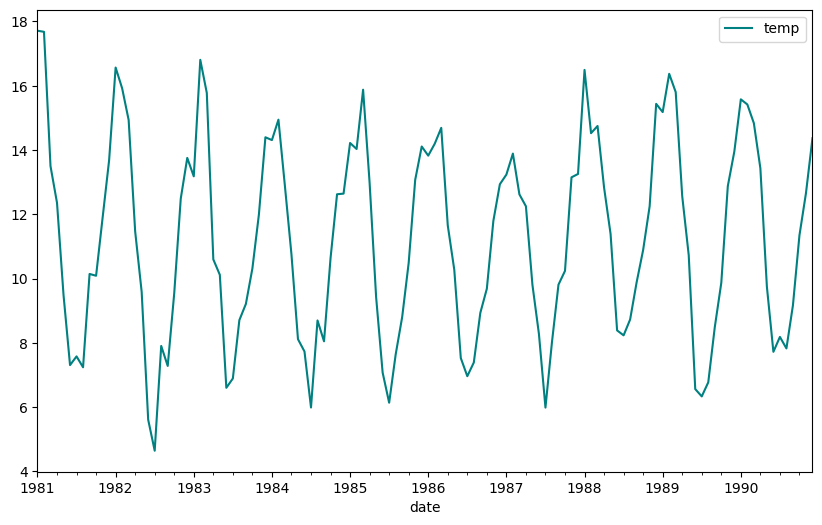

In [5]:
data.plot(y='temp', color='teal', figsize=(10,6))

In [6]:
# Membuat dummy variabel bulan
data = pd.get_dummies(data, columns=['month'])

In [7]:
# Menambahkan variabel tren
data['Trend'] = np.arange(1, len(data)+1)
data.drop(['year','day'], axis = 1, inplace = True)
data

,temp,month_1.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0,month_10.0,month_11.0,month_12.0,Trend
date,,,,,,,,,,,,,,
1981-01-01,17.712903,True,False,False,False,False,False,False,False,False,False,False,False,1
1981-02-01,17.678571,False,True,False,False,False,False,False,False,False,False,False,False,2
1981-03-01,13.500000,False,False,True,False,False,False,False,False,False,False,False,False,3
1981-04-01,12.356667,False,False,False,True,False,False,False,False,False,False,False,False,4
1981-05-01,9.490323,False,False,False,False,True,False,False,False,False,False,False,False,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990-08-01,7.825806,False,False,False,False,False,False,False,True,False,False,False,False,116
1990-09-01,9.166667,False,False,False,False,False,False,False,False,True,False,False,False,117
1990-10-01,11.345161,False,False,False,False,False,False,False,False,False,True,False,False,118


## Panjang

In [8]:
train_data = data.iloc[:72]
test_data = data.iloc[72:]

In [9]:
X= train_data.iloc[:,3:]
X.columns

Index(['month_3.0', 'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0',
       'month_8.0', 'month_9.0', 'month_10.0', 'month_11.0', 'month_12.0',
       'Trend'],
      dtype='object')

In [10]:
# Membuat model regresi linear dengan scikit-learn
X_train = train_data[['Trend'] + [col for col in data.columns if 'month' in col]]
y_train = train_data['temp']
model_sm = sm.OLS(y_train, X_train.astype(float)).fit()
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   temp   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     57.46
Date:                Wed, 03 Jan 2024   Prob (F-statistic):           5.73e-28
Time:                        10:22:47   Log-Likelihood:                -94.794
No. Observations:                  72   AIC:                             215.6
Df Residuals:                      59   BIC:                             245.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Trend         -0.0077      0.006     -1.343      0.185      -0.019       0.004
month_1.0     15.2080      0.444     34.235      0.000      14.319      16.097
month_2.0     15.8431      0.447     35.479      0.000      14.950      16.737
month_3.0     14.8621      0.449     33.105      0.000      13.964      15.760
month_4.0     11.8957      0.451     26.354      0.000      10.992      12.799
month_5.0      9.7689      0.454     21.522      0.000       8.861      10.677
month_6.0      7.2510      0.456     15.885      0.000       6.338       8.164
month_7.0      6.6505      0.459     14.486      0.000       5.732       7.569
month_8.0      8.2205      0.462     17.803      0.000       7.297       9.144
month_9.0      9.0364      0.464     19.454      0.000       8.107       9.966
month_10.0    10.4332      0.467     22.328      0.000       9.498      11.368
month_11.0    12.6257      0.470     26.856      0.000      11.685      13.566
month_12.0    13.9101      0.473     29.407      0.000      12.964      14.857
==============================================================================
Omnibus:                        0.038   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.981   Jarque-Bera (JB):                0.089
Skew:                           0.048   Prob(JB):                        0.956
Kurtosis:                       2.857   Cond. No.                         298.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
# Membuat prediksi untuk data test
X_test = test_data[['Trend'] + [col for col in data.columns if 'month' in col]]
test_data['Predictions'] = model_sm.predict(X_test)

C:\Users\fikri\AppData\Local\Temp\ipykernel_11012\3990571357.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predictions'] = model_sm.predict(X_test)


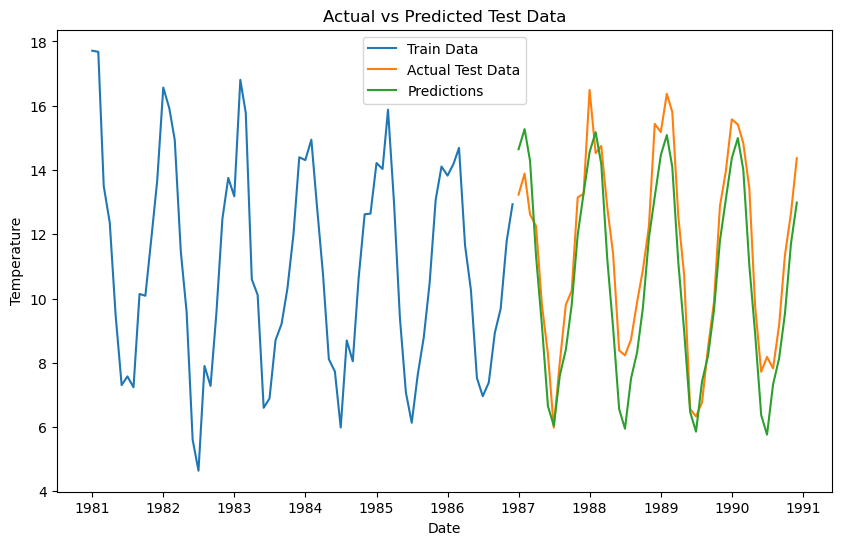

In [12]:
# Pastikan DataFrame diurutkan berdasarkan indeks datetime
test_data.sort_index(inplace=True)

# Mengonversi indeks datetime menjadi array
date_train = train_data.index.values
date_test = test_data.index.values

# Mengonversi y_train menjadi array
y_train = train_data['temp'].values

# Mengonversi 'temp' dan 'Predictions' menjadi array
temp_actual = test_data['temp'].values
predictions = test_data['Predictions'].values

# Menampilkan plot hasil prediksi
plt.figure(figsize=(10, 6))
plt.plot(date_train, y_train, label='Train Data')
plt.plot(date_test, temp_actual, label='Actual Test Data')
plt.plot(date_test, predictions, label='Predictions')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Test Data')
plt.show()


In [13]:
# Menghitung metrik evaluasi untuk data uji
mse_test = mean_squared_error(test_data['temp'], test_data['Predictions'])
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(test_data['temp'], test_data['Predictions'])
mape_test = np.mean(np.abs((test_data['temp'] - test_data['Predictions']) / test_data['temp'])) * 100

print("\nMetrik evaluasi untuk data uji:")
print(f"MSE: {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"MAE: {mae_test}")
print(f"MAPE: {mape_test}")


Metrik evaluasi untuk data uji:
MSE: 1.7198255420690292
RMSE: 1.3114211917111258
MAE: 1.137566632573188
MAPE: 10.245702128289116


## Pendek

In [14]:
train_data_pendek = data.iloc[:108]
test_data_pendek = data.iloc[108:]

In [15]:
X_pendek= train_data_pendek.iloc[:,3:]
X_pendek.columns

Index(['month_3.0', 'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0',
       'month_8.0', 'month_9.0', 'month_10.0', 'month_11.0', 'month_12.0',
       'Trend'],
      dtype='object')

In [16]:
X_train_pendek = train_data_pendek[['Trend'] + [col for col in data.columns if 'month' in col]]
y_train_pendek = train_data_pendek['temp']
model_sm_pendek = sm.OLS(y_train_pendek, X_train_pendek.astype(float)).fit()
model_sm_pendek.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   temp   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     80.33
Date:                Wed, 03 Jan 2024   Prob (F-statistic):           3.14e-44
Time:                        10:22:48   Log-Likelihood:                -146.76
No. Observations:                 108   AIC:                             319.5
Df Residuals:                      95   BIC:                             354.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Trend          0.0028      0.003      0.891      0.375      -0.003       0.009
month_1.0     14.8333      0.368     40.316      0.000      14.103      15.564
month_2.0     15.2350      0.369     41.261      0.000      14.502      15.968
month_3.0     14.3937      0.371     38.843      0.000      13.658      15.129
month_4.0     11.7944      0.372     31.713      0.000      11.056      12.533
month_5.0      9.7323      0.373     26.072      0.000       8.991      10.473
month_6.0      7.0792      0.375     18.894      0.000       6.335       7.823
month_7.0      6.3740      0.376     16.948      0.000       5.627       7.121
month_8.0      7.7429      0.378     20.510      0.000       6.993       8.492
month_9.0      8.7968      0.379     23.212      0.000       8.044       9.549
month_10.0    10.0331      0.380     26.372      0.000       9.278      10.788
month_11.0    12.2960      0.382     32.194      0.000      11.538      13.054
month_12.0    13.6292      0.383     35.544      0.000      12.868      14.390
==============================================================================
Omnibus:                        0.707   Durbin-Watson:                   1.444
Prob(Omnibus):                  0.702   Jarque-Bera (JB):                0.507
Skew:                           0.167   Prob(JB):                        0.776
Kurtosis:                       3.033   Cond. No.                         441.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
X_test_pendek = test_data_pendek[['Trend'] + [col for col in data.columns if 'month' in col]]
test_data_pendek['Predictions'] = model_sm_pendek.predict(X_test_pendek)

C:\Users\fikri\AppData\Local\Temp\ipykernel_11012\1367348946.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_pendek['Predictions'] = model_sm_pendek.predict(X_test_pendek)


In [18]:
test_data_pendek['Predictions']

date
1990-01-01    15.136301
1990-02-01      15.5407
1990-03-01    14.702251
1990-04-01    12.105656
1990-05-01    10.046337
1990-06-01     7.396026
1990-07-01     6.693649
1990-08-01     8.065333
1990-09-01     9.121952
1990-10-01    10.361032
1990-11-01    12.626767
1990-12-01    13.962753
Freq: MS, Name: Predictions, dtype: object

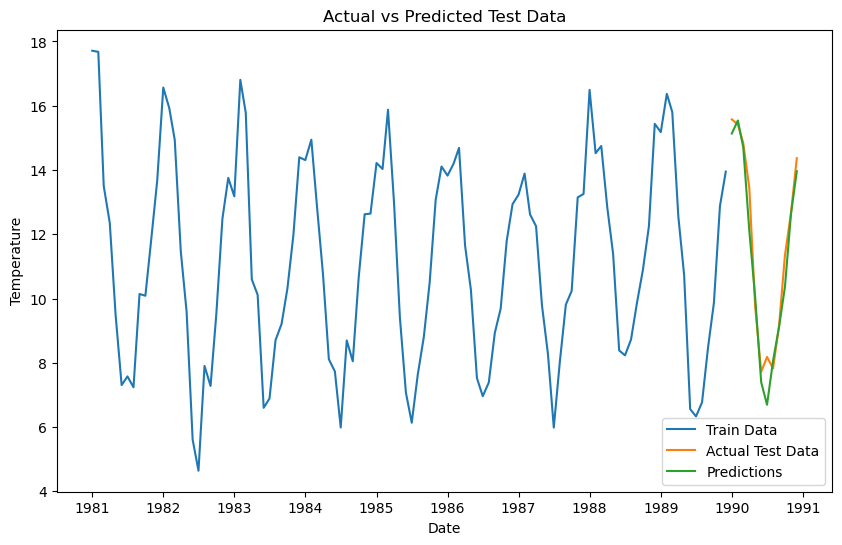

In [19]:
# Pastikan DataFrame diurutkan berdasarkan indeks datetime
test_data_pendek.sort_index(inplace=True)

# Mengonversi indeks datetime menjadi array
date_train_pendek = train_data_pendek.index.values
date_test_pendek = test_data_pendek.index.values

# Mengonversi y_train menjadi array
y_train_pendek = train_data_pendek['temp'].values

# Mengonversi 'temp' dan 'Predictions' menjadi array
temp_actual_pendek = test_data_pendek['temp'].values
predictions_pendek = test_data_pendek['Predictions'].values

# Menampilkan plot hasil prediksi
plt.figure(figsize=(10, 6))
plt.plot(date_train_pendek, y_train_pendek, label='Train Data')
plt.plot(date_test_pendek, temp_actual_pendek, label='Actual Test Data')
plt.plot(date_test_pendek, predictions_pendek, label='Predictions')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Actual vs Predicted Test Data')
plt.show()

In [20]:
# Menghitung metrik evaluasi untuk data uji
mse_test_pendek = mean_squared_error(test_data_pendek['temp'], test_data_pendek['Predictions'])
rmse_test_pendek = np.sqrt(mse_test_pendek)
mae_test_pendek = mean_absolute_error(test_data_pendek['temp'], test_data_pendek['Predictions'])
mape_test_pendek = np.mean(np.abs((test_data_pendek['temp'] - test_data_pendek['Predictions']) / test_data_pendek['temp'])) * 100

print("\nMetrik evaluasi untuk data uji:")
print(f"MSE: {mse_test_pendek}")
print(f"RMSE: {rmse_test_pendek}")
print(f"MAE: {mae_test_pendek}")
print(f"MAPE: {mape_test_pendek}")


Metrik evaluasi untuk data uji:
MSE: 0.46645337971781387
RMSE: 0.6829739231609168
MAE: 0.4866896042266258
MAPE: 4.5958500943502925


In [21]:
import pandas as pd

# Data untuk model pertama
linear_regression_metrics = {
    'Model Linear Regression': ['Panjang'],
    'MSE': [mse_test],
    'RMSE': [rmse_test],
    'MAE': [mae_test],
    'MAPE': [mape_test]
}

# Data untuk model kedua (dengan tambahan "_pendek" untuk membedakan)
linear_regression_metrics_pendek = {
    'Model Linear Regression': ['Pendek'],
    'MSE': [mse_test_pendek],
    'RMSE': [rmse_test_pendek],
    'MAE': [mae_test_pendek],
    'MAPE': [mape_test_pendek]
}

# Membuat DataFrame untuk masing-masing model
df_model1 = pd.DataFrame(linear_regression_metrics)
df_model2 = pd.DataFrame(linear_regression_metrics_pendek)

# Menggabungkan DataFrame untuk perbandingan
df_comparison = pd.concat([df_model1, df_model2], ignore_index=True)

# Menampilkan DataFrame
df_comparison


,Model Linear Regression,MSE,RMSE,MAE,MAPE
0,Panjang,1.719826,1.311421,1.137567,10.245702
1,Pendek,0.466453,0.682974,0.486690,4.595850


# SARIMA

In [23]:
df = pd.read_csv("csv/daily-minimum-temperatures.csv")
df

,date,temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3650 non-null   object 
 1   temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


In [27]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# Misalkan df adalah DataFrame dengan kolom 'timestamp' dan 'value'
result = adfuller(df['temp'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] <= 0.05:
    print("Hasil uji menunjukkan deret waktu stasioner (Tolak H0)")
else:
    print("Hasil uji menunjukkan deret waktu tidak stasioner (Gagal tolak H0)")


ADF Statistic: -4.444804924611687
p-value: 0.00024708263003611164
Hasil uji menunjukkan deret waktu stasioner (Tolak H0)


In [29]:
adf_result = stattools.adfuller(df['temp'], autolag = 'AIC')
adf_result

(-4.444804924611687,
 0.00024708263003611164,
 20,
 3629,
 {'1%': -3.4321532327220154,
  '5%': -2.862336767636517,
  '10%': -2.56719413172842},
 16642.822304301197)

In [31]:
# Mengubah kolom 'date' menjadi datetime
df['date'] = pd.to_datetime(df['date'])

# Mengatur kolom 'date' sebagai indeks
df.set_index('date', inplace=True)

df = df.resample('MS').mean()

# Tampilkan hasilnya
df

,temp
date,
1981-01-01,17.712903
1981-02-01,17.678571
1981-03-01,13.500000
1981-04-01,12.356667
1981-05-01,9.490323
...,...
1990-08-01,7.825806
1990-09-01,9.166667
1990-10-01,11.345161


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 1981-01-01 to 1990-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    120 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


In [27]:
# results = {}

# train_data = df.iloc[:72]
# test_data = df.iloc[72:]

# d = 0 # non-seasonal difference order
# D = 0 # Seasonal difference order
# m = 12 # The number of time steps for a single seasonal period

# for p in [1,2, 8, 21]: # non-seasonal autoregressive lag polynomial
#     for q in [1,2, 3]: # non-seasonal moving average order
#         for P in [0, 1]: # Seasonal autoregressive order
#             for Q in [1]: # Seasonal moving average order
                

#                 try:
#                     model = SARIMAX(df['temp'], order=(p,d,q), seasonal_order=(P,D,Q, m), simple_differencing=False)
#                     res = model.fit(disp=False)

#                     sse = sum(res.resid**2)
#                     test = acorr_ljungbox(res.resid, lags=int(round(np.log(len(res.resid)),0)))

#                     results[f"Sarima{str((p,d,q, P,D,Q, m))}"] = {"AIC": res.aic, "SSE": sse, "p-value": test['lb_pvalue'].values[-1]}
#                 except ValueError:
#                     continue
                    
# hasil = pd.DataFrame(results)
# hasil.T.sort_values(['AIC'])

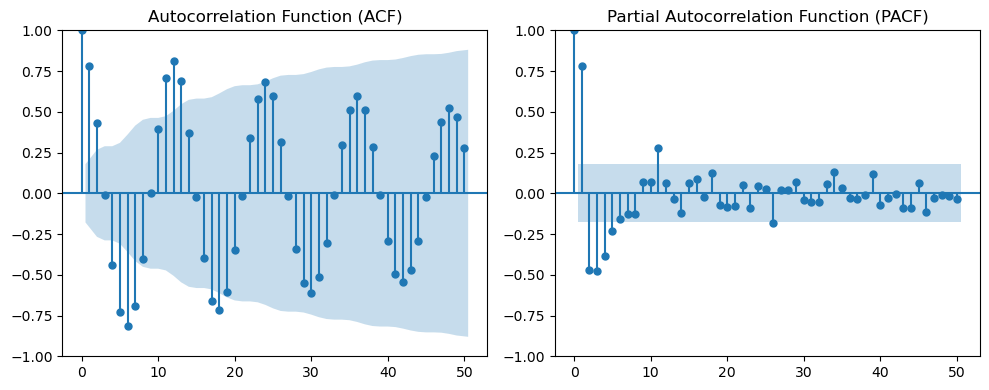

In [28]:
# Create subplots
significance_level = 0.05
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# ACF plot with significant lines
sm.graphics.tsa.plot_acf(df['temp'], lags=50, alpha=significance_level,ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# PACF plot with significant lines
sm.graphics.tsa.plot_pacf(df['temp'], lags=50, alpha=significance_level,ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


Model SARIMAX adalah model ARIMA yang menambahkan komponen musiman. Dalam hal ini, komponen musiman dapat dimodelkan dengan AR(P), MA(Q), atau keduanya.

Berdasarkan interpretasi terhadap plot ACF dan PACF, model ARIMA yang paling mungkin untuk data ini adalah ARIMA(1,0,1) atau ARIMA(2,0,1). Oleh karena itu, model SARIMAX yang paling mungkin untuk data ini adalah SARIMAX(1,0,1)(1,0,1)_12 atau SARIMAX(2,0,1)(1,0,1)_12.

Model SARIMAX(1,0,1)(1,0,1)_12 memiliki orde p = 1, d = 0, q = 1 untuk komponen non-musiman, dan orde P = 1, Q = 1 untuk komponen musiman. Model SARIMAX(2,0,1)(1,0,1)_12 memiliki orde p = 2, d = 0, q = 1 untuk komponen non-musiman, dan orde P = 1, Q = 1 untuk komponen musiman.

Untuk menentukan model mana yang lebih baik, perlu dilakukan uji statistik lebih lanjut. Uji statistik yang umum digunakan untuk menentukan model SARIMAX yang terbaik adalah uji AIC.

Berikut adalah penjelasan lebih rinci tentang model SARIMAX:

Orde p
Orde p untuk komponen non-musiman sama dengan orde p untuk model ARIMA yang dipertimbangkan. Dalam hal ini, orde p = 1 atau 2.

Orde d
Orde d untuk komponen non-musiman sama dengan orde d untuk model ARIMA yang dipertimbangkan. Dalam hal ini, orde d = 0.

Orde q
Orde q untuk komponen non-musiman sama dengan orde q untuk model ARIMA yang dipertimbangkan. Dalam hal ini, orde q = 1.

Orde P
Orde P untuk komponen musiman adalah orde AR yang digunakan untuk model musiman. Dalam hal ini, orde P = 1.

Orde Q
Orde Q untuk komponen musiman adalah orde MA yang digunakan untuk model musiman. Dalam hal ini, orde Q = 1.

Periode musiman
Periode musiman adalah panjang satu periode musiman. Dalam hal ini, periode musiman adalah 12, karena data memiliki periode musiman tahunan.

Dengan demikian, model SARIMAX yang paling mungkin untuk data ini adalah SARIMAX(1,0,1)(1,0,1)_12 atau SARIMAX(2,0,1)(1,0,1)_12. Untuk menentukan model mana yang lebih baik, perlu dilakukan uji statistik lebih lanjut.

In [29]:
model=SARIMAX(df['temp'],order=(2,0,2),seasonal_order=(1,0,1,12))
results=model.fit()
results.summary()

C:\Users\fikri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\fikri\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 temp   No. Observations:                  120
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                -189.907
Date:                              Wed, 03 Jan 2024   AIC                            393.814
Time:                                      10:22:49   BIC                            413.326
Sample:                                  01-01-1981   HQIC                           401.738
                                       - 12-01-1990                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0183      0.088      0.207      0.836      -0.155       0.191
ar.L2          0.9149      0.082     11.191      0.000       0.755       1.075
ma.L1          0.2765      0.083      3.341      0.001       0.114       0.439
ma.L2         -0.7177      0.080     -8.955      0.000      -0.875      -0.561
ar.S.L12       0.9989      0.002    527.439      0.000       0.995       1.003
ma.S.L12      -0.8410      0.131     -6.399      0.000      -1.099      -0.583
sigma2         0.9613      0.175      5.506      0.000       0.619       1.304
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.81
Prob(Q):                              0.99   Prob(JB):                         0.67
Heteroskedasticity (H):               0.54   Skew:                             0.14
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## panjang

In [30]:
train_data = df.iloc[:72]
test_data = df.iloc[72:]

start = len(train_data)
end = len(train_data) + len(test_data) - 1

predictions1 = results.predict(start, end,typ='levels').rename('SARIMA Predictions')

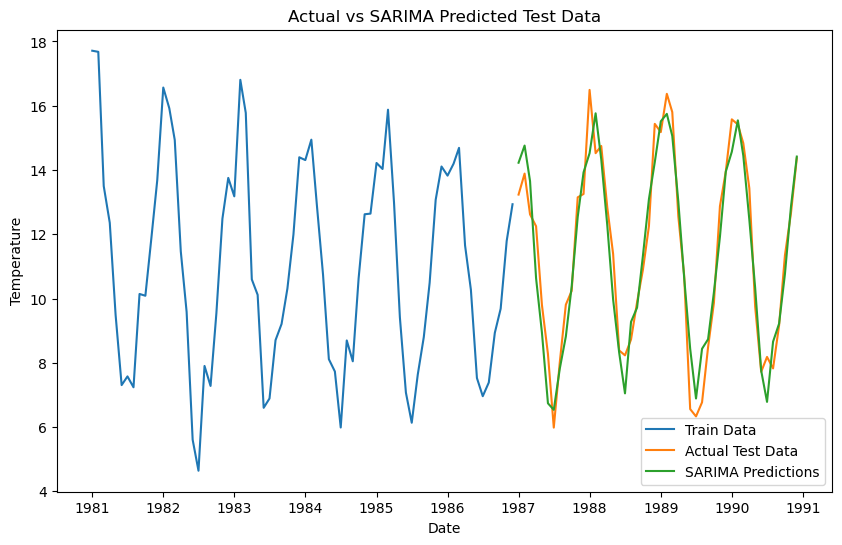

In [31]:
# Pastikan DataFrame diurutkan berdasarkan indeks datetime
train_data.sort_index(inplace=True)
test_data.sort_index(inplace=True)

# Mengonversi indeks datetime menjadi array
date_train = train_data.index.values
date_test = test_data.index.values

# Mengonversi y_train menjadi array
y_train = train_data['temp'].values

# Mengonversi 'temp' dan 'SARIMA Predictions' menjadi array
temp_actual = test_data['temp'].values
predictions = predictions1.values

# Menampilkan plot hasil prediksi
plt.figure(figsize=(10, 6))
plt.plot(date_train, y_train, label='Train Data')
plt.plot(date_test, temp_actual, label='Actual Test Data')
plt.plot(date_test, predictions, label='SARIMA Predictions')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Actual vs SARIMA Predicted Test Data')
plt.show()


In [32]:
# Menghitung metrik evaluasi untuk data uji
mse_test = mean_squared_error(test_data['temp'], predictions1)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(test_data['temp'], predictions1)
mape_test = np.mean(np.abs((test_data['temp'] - predictions1) / test_data['temp'])) * 100

# Menampilkan metrik evaluasi
print("\nMetrik evaluasi untuk data uji:")
print(f"MSE: {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"MAE: {mae_test}")
print(f"MAPE: {mape_test}")



Metrik evaluasi untuk data uji:
MSE: 0.7737263220591594
RMSE: 0.879617145159847
MAE: 0.7126830416576498
MAPE: 6.810616971306699


## pendek

In [33]:
train_data_pendek = df.iloc[:108]
test_data_pendek = df.iloc[108:]

start_pendek = len(train_data_pendek)
end_pendek = len(train_data_pendek) + len(test_data_pendek) - 1

predictions_pendek = results.predict(start_pendek,end_pendek,typ='levels').rename('SARIMA Predictions')

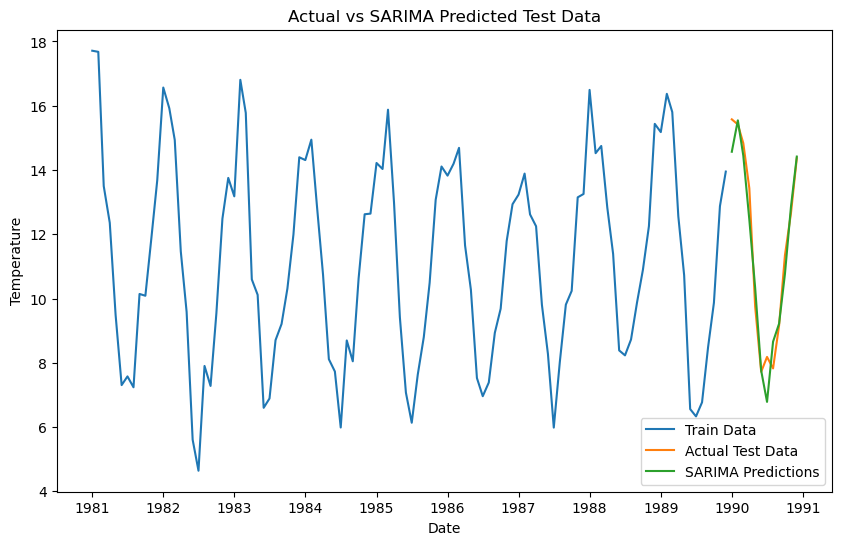

In [34]:
# Pastikan DataFrame diurutkan berdasarkan indeks datetime
train_data_pendek.sort_index(inplace=True)
test_data_pendek.sort_index(inplace=True)

# Mengonversi indeks datetime menjadi array
date_train = train_data_pendek.index.values
date_test = test_data_pendek.index.values

# Mengonversi y_train menjadi array
y_train = train_data_pendek['temp'].values

# Mengonversi 'temp' dan 'SARIMA Predictions' menjadi array
temp_actual = test_data_pendek['temp'].values
predictions_pendek = predictions_pendek.values

# Menampilkan plot hasil prediksi
plt.figure(figsize=(10, 6))
plt.plot(date_train, y_train, label='Train Data')
plt.plot(date_test, temp_actual, label='Actual Test Data')
plt.plot(date_test, predictions_pendek, label='SARIMA Predictions')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Actual vs SARIMA Predicted Test Data')
plt.show()


In [35]:
# Menghitung metrik evaluasi untuk data uji
mse_test_pendek = mean_squared_error(test_data_pendek['temp'], predictions_pendek)
rmse_test_pendek = np.sqrt(mse_test_pendek)
mae_test_pendek = mean_absolute_error(test_data_pendek['temp'], predictions_pendek)
mape_test_pendek = np.mean(np.abs((test_data_pendek['temp'] - predictions_pendek) / test_data_pendek['temp'])) * 100

# Menampilkan metrik evaluasi
print("\nMetrik evaluasi untuk data uji:")
print(f"MSE: {mse_test_pendek}")
print(f"RMSE: {rmse_test_pendek}")
print(f"MAE: {mae_test_pendek}")
print(f"MAPE: {mape_test_pendek}")



Metrik evaluasi untuk data uji:
MSE: 0.4597733333121495
RMSE: 0.6780658768232991
MAE: 0.5197472666287958
MAPE: 4.9170365834751495


In [36]:
import pandas as pd

# Data untuk model pertama
linear_regression_metrics = {
    'SARIMA': ['Panjang'],
    'MSE': [mse_test],
    'RMSE': [rmse_test],
    'MAE': [mae_test],
    'MAPE': [mape_test]
}

# Data untuk model kedua (dengan tambahan "_pendek" untuk membedakan)
linear_regression_metrics_pendek = {
    'SARIMA': ['Pendek'],
    'MSE': [mse_test_pendek],
    'RMSE': [rmse_test_pendek],
    'MAE': [mae_test_pendek],
    'MAPE': [mape_test_pendek]
}

# Membuat DataFrame untuk masing-masing model
df_model1 = pd.DataFrame(linear_regression_metrics)
df_model2 = pd.DataFrame(linear_regression_metrics_pendek)

# Menggabungkan DataFrame untuk perbandingan
df_comparison = pd.concat([df_model1, df_model2], ignore_index=True)

# Menampilkan DataFrame
df_comparison


,SARIMA,MSE,RMSE,MAE,MAPE
0,Panjang,0.773726,0.879617,0.712683,6.810617
1,Pendek,0.459773,0.678066,0.519747,4.917037


# SARIMAX

In [37]:
#residual dari time series regression
residual = model_sm.resid
len(residual)
residual

date
1981-01-01    2.512582
1981-02-01    1.850848
1981-03-01   -1.339031
1981-04-01    0.491811
1981-05-01   -0.240106
                ...   
1986-08-01   -0.309894
1986-09-01    0.428189
1986-10-01   -0.210431
1986-11-01   -0.285700
1986-12-01   -0.420342
Freq: MS, Length: 72, dtype: float64

In [38]:
#residual dari time series regression
residual_pendek = model_sm_pendek.resid
len(residual_pendek)
residual_pendek

date
1981-01-01    2.876783
1981-02-01    2.438053
1981-03-01   -0.902070
1981-04-01    0.551192
1981-05-01   -0.255834
                ...   
1989-08-01   -1.261012
1989-09-01   -0.601932
1989-10-01   -0.459937
1989-11-01    0.283253
1989-12-01    0.022213
Freq: MS, Length: 108, dtype: float64

In [39]:
from statsmodels.tsa import stattools
adf_result = stattools.adfuller(residual_pendek, autolag='AIC')

print(f'p-val of the ADF test: {adf_result}')
if adf_result[1]<0.05:
    print('data stasioner')
else:
    print('data tidak stasioner')

p-val of the ADF test: (-6.067523274618241, 1.1720526047513843e-07, 1, 106, {'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10%': -2.58153320754717}, 237.5976440743113)
data stasioner


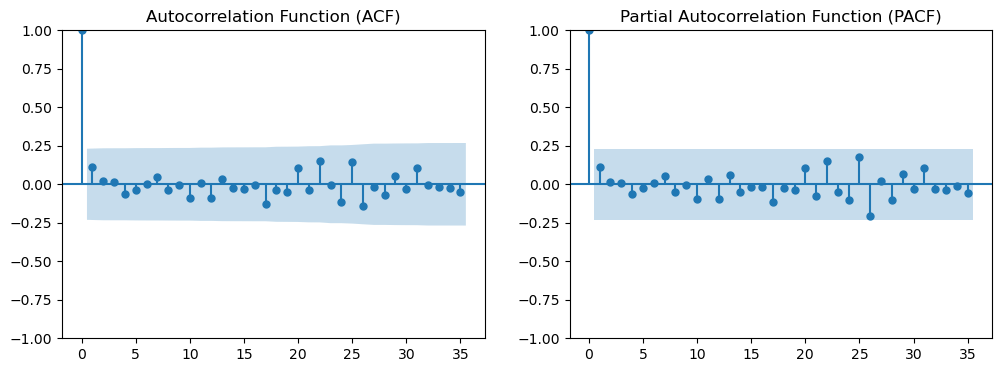

In [40]:
acfresult = sm.tsa.acf(residual,fft=False)
pacfresult = sm.tsa.pacf(residual,method='ols')

sl=0.05
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

sm.graphics.tsa.plot_acf(residual, lags=35, alpha=sl, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# PACF plot with significant lines 
sm.graphics.tsa.plot_pacf(residual, lags=35, alpha=sl, ax=ax2) 
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout
plt.show()

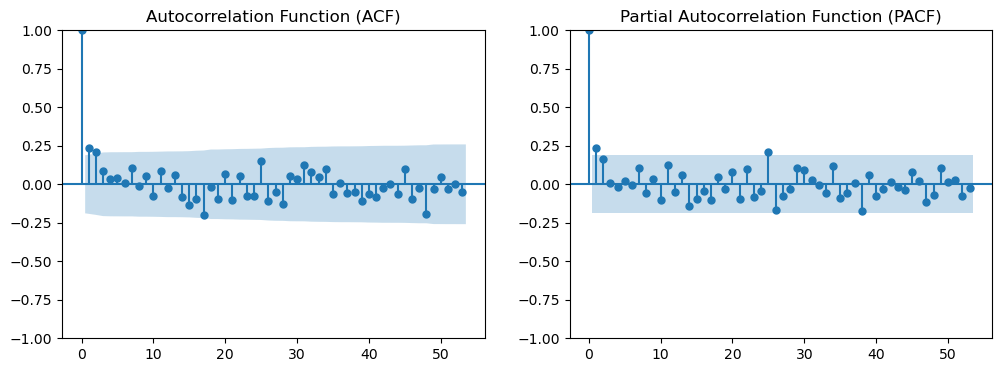

In [41]:
acfresult = sm.tsa.acf(residual,fft=False)
pacfresult = sm.tsa.pacf(residual,method='ols')

sl=0.05
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

sm.graphics.tsa.plot_acf(residual_pendek, lags=53, alpha=sl, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# PACF plot with significant lines 
sm.graphics.tsa.plot_pacf(residual_pendek, lags=53, alpha=sl, ax=ax2) 
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout
plt.show()

In [42]:
# results = {}

# train_data = df1.iloc[:72]
# test_data = df1.iloc[72:]

# d = 0 # non-seasonal difference order
# D = 0 # Seasonal difference order
# m = 12 # The number of time steps for a single seasonal period

# for p in [1,2, 8, 21]: # non-seasonal autoregressive lag polynomial
#     for q in [1,2, 3]: # non-seasonal moving average order
#         for P in [0, 1]: # Seasonal autoregressive order
#             for Q in [1]: # Seasonal moving average order
                

#                 try:
#                     model = SARIMAX(train_data['temp'], order=(p,d,q), seasonal_order=(P,D,Q, m), simple_differencing=False)
#                     res = model.fit(disp=False)

#                     sse = sum(res.resid**2)
#                     test = acorr_ljungbox(res.resid, lags=int(round(np.log(len(res.resid)),0)))

#                     results[f"Sarima{str((p,d,q, P,D,Q, m))}"] = {"AIC": res.aic, "SSE": sse, "p-value": test['lb_pvalue'].values[-1]}
#                 except ValueError:
#                     continue
                    
# hasil = pd.DataFrame(results)
# hasil.T.sort_values(['AIC'])

In [43]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(model_sm.resid, order=(1,0,1), seasonal_order=(1,0,1,12)).fit()
model.summary()

C:\Users\fikri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\fikri\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                   72
Model:             ARIMA(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 -89.107
Date:                          Wed, 03 Jan 2024   AIC                            190.213
Time:                                  10:22:50   BIC                            203.873
Sample:                              01-01-1981   HQIC                           195.651
                                   - 12-01-1986                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0135      0.071     -0.189      0.850      -0.153       0.126
ar.L1         -0.0224      0.840     -0.027      0.979      -1.669       1.624
ma.L1          0.1703      0.856      0.199      0.842      -1.508       1.848
ar.S.L12       0.4641      0.268      1.732      0.083      -0.061       0.989
ma.S.L12      -0.9968     22.939     -0.043      0.965     -45.956      43.963
sigma2         0.5749     13.052      0.044      0.965     -25.006      26.156
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.21
Prob(Q):                              0.96   Prob(JB):                         0.55
Heteroskedasticity (H):               0.40   Skew:                             0.32
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
from statsmodels.tsa.arima.model import ARIMA
model_pendek = ARIMA(model_sm_pendek.resid, order=(1,0,2), seasonal_order=(1,0,1,12)).fit()
model_pendek.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  108
Model:             ARIMA(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                -136.450
Date:                            Wed, 03 Jan 2024   AIC                            286.899
Time:                                    10:22:51   BIC                            305.674
Sample:                                01-01-1981   HQIC                           294.512
                                     - 12-01-1989                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0093      0.085     -0.109      0.913      -0.176       0.157
ar.L1          0.3157      0.478      0.660      0.509      -0.621       1.253
ma.L1         -0.0640      0.496     -0.129      0.897      -1.036       0.907
ma.L2          0.1631      0.157      1.041      0.298      -0.144       0.470
ar.S.L12       0.6693      0.237      2.825      0.005       0.205       1.134
ma.S.L12      -0.9998    194.825     -0.005      0.996    -382.849     380.850
sigma2         0.6531    127.108      0.005      0.996    -248.474     249.781
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 1.08
Prob(Q):                              0.79   Prob(JB):                         0.58
Heteroskedasticity (H):               0.51   Skew:                             0.19
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Panjang

In [45]:
forecast = model.get_forecast(steps=48).summary_frame(alpha=0.05)
e_pred = forecast['mean']
zt = model_sm.predict(X_test)+e_pred
zt

date
1987-01-01    15.259021
1987-02-01    15.905009
1987-03-01    13.970274
1987-04-01     11.14066
1987-05-01     8.998075
1987-06-01     6.312718
1987-07-01      5.89261
1987-08-01     7.472416
1987-09-01     8.359483
1987-10-01      9.63259
1987-11-01     11.79437
1987-12-01    13.237791
1988-01-01    14.858253
1988-02-01    15.466309
1988-03-01    14.039182
1988-04-01    11.132084
1988-05-01     8.993871
1988-06-01     6.394141
1988-07-01     5.873183
1988-08-01     7.443643
1988-09-01     8.288421
1988-10-01     9.623719
1988-11-01    11.797799
1988-12-01    13.151924
1989-01-01    14.595386
1989-02-01     15.21381
1989-03-01    14.021639
1989-04-01    11.078594
1989-05-01      8.94241
1989-06-01     6.382421
1989-07-01     5.814658
1989-08-01      7.38078
1989-09-01     8.205931
1989-10-01     9.570092
1989-11-01     11.74988
1989-12-01    13.062563
1990-01-01     14.42388
1990-02-01    15.047115
1990-03-01    13.963987
1990-04-01    11.004259
1990-05-01     8.869017
1990-06-01 

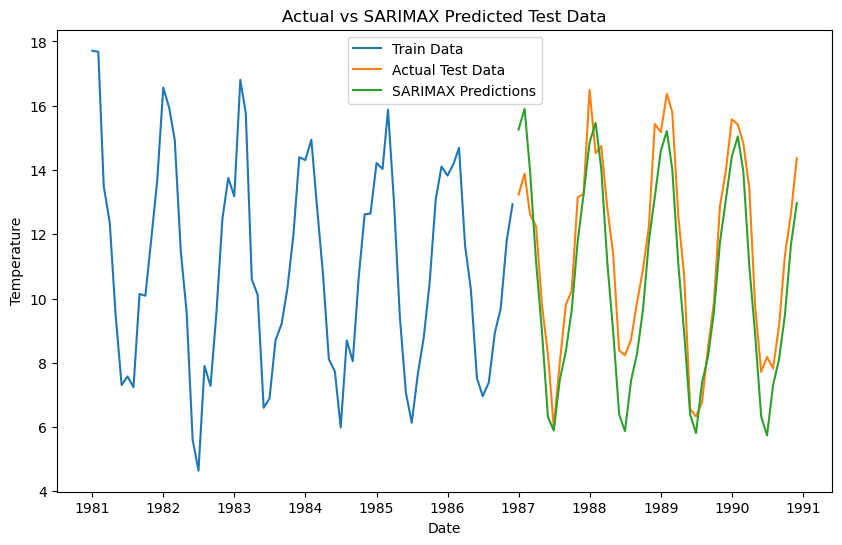

In [46]:
# Pastikan DataFrame diurutkan berdasarkan indeks datetime
train_data.sort_index(inplace=True)
test_data.sort_index(inplace=True)

# Mengonversi indeks datetime menjadi array
date_train = train_data.index.values
date_test = test_data.index.values

# Mengonversi y_train menjadi array
y_train = train_data['temp'].values

# Mengonversi 'temp' dan 'SARIMA Predictions' menjadi array
temp_actual = test_data['temp'].values
zt = zt.values

# Menampilkan plot hasil prediksi
plt.figure(figsize=(10, 6))
plt.plot(date_train, y_train, label='Train Data')
plt.plot(date_test, temp_actual, label='Actual Test Data')
plt.plot(date_test, zt, label='SARIMAX Predictions')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Actual vs SARIMAX Predicted Test Data')
plt.show()


In [47]:
# Menghitung metrik evaluasi untuk data uji
mse_test = mean_squared_error(test_data['temp'], zt)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(test_data['temp'], zt)
mape_test = np.mean(np.abs((test_data['temp'] - zt) / test_data['temp'])) * 100

# Menampilkan metrik evaluasi
print("\nMetrik evaluasi untuk data uji:")
print(f"MSE: {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"MAE: {mae_test}")
print(f"MAPE: {mape_test}")



Metrik evaluasi untuk data uji:
MSE: 1.9049399086754792
RMSE: 1.3801956052224913
MAE: 1.2080585384952915
MAPE: 10.926704142298364


## Pendek

In [48]:
forecast_pendek = model_pendek.get_forecast(steps=12).summary_frame(alpha=0.05)
e_pred_pendek = forecast_pendek['mean']
zt_pendek = model_sm_pendek.predict(X_test_pendek) + e_pred_pendek
zt_pendek

date
1990-01-01     15.53105
1990-02-01    15.993864
1990-03-01     14.64487
1990-04-01    11.919975
1990-05-01     9.791913
1990-06-01      7.22036
1990-07-01     6.600802
1990-08-01     8.137023
1990-09-01     9.064722
1990-10-01    10.323032
1990-11-01    12.496732
1990-12-01    13.821664
Freq: MS, dtype: object

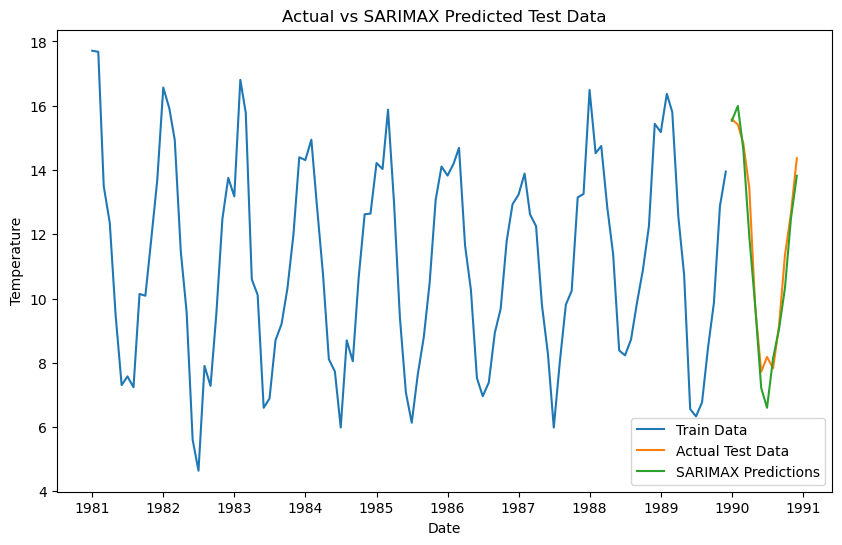

In [49]:
# Pastikan DataFrame diurutkan berdasarkan indeks datetime
train_data.sort_index(inplace=True)
test_data.sort_index(inplace=True)

# Mengonversi indeks datetime menjadi array
date_train = train_data.index.values
date_test = test_data.index.values

# Mengonversi y_train menjadi array
y_train = train_data['temp'].values

# Mengonversi 'temp' dan 'SARIMA Predictions' menjadi array
temp_actual = test_data['temp'].values
zt_pendek = zt_pendek.values

# Menampilkan plot hasil prediksi
plt.figure(figsize=(10, 6))
plt.plot(date_train_pendek, y_train_pendek, label='Train Data')
plt.plot(date_test_pendek, temp_actual_pendek, label='Actual Test Data')
plt.plot(date_test_pendek, zt_pendek, label='SARIMAX Predictions')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Actual vs SARIMAX Predicted Test Data')
plt.show()


In [50]:
# Menghitung metrik evaluasi untuk data uji
mse_test_pendek = mean_squared_error(test_data_pendek['temp'], zt_pendek)
rmse_test_pendek = np.sqrt(mse_test_pendek)
mae_test_pendek = mean_absolute_error(test_data_pendek['temp'], zt_pendek)
mape_test_pendek = np.mean(np.abs((test_data_pendek['temp'] - zt_pendek) / test_data_pendek['temp'])) * 100

# Menampilkan metrik evaluasi
print("\nMetrik evaluasi untuk data uji:")
print(f"MSE: {mse_test_pendek}")
print(f"RMSE: {rmse_test_pendek}")
print(f"MAE: {mae_test_pendek}")
print(f"MAPE: {mape_test_pendek}")



Metrik evaluasi untuk data uji:
MSE: 0.5744952337749972
RMSE: 0.7579546383359609
MAE: 0.5494906100316806
MAPE: 5.1674291551079685


In [51]:
import pandas as pd

# Data untuk model pertama
linear_regression_metrics = {
    'SARIMAX': ['Panjang'],
    'MSE': [mse_test],
    'RMSE': [rmse_test],
    'MAE': [mae_test],
    'MAPE': [mape_test]
}

# Data untuk model kedua (dengan tambahan "_pendek" untuk membedakan)
linear_regression_metrics_pendek = {
    'SARIMAX': ['Pendek'],
    'MSE': [mse_test_pendek],
    'RMSE': [rmse_test_pendek],
    'MAE': [mae_test_pendek],
    'MAPE': [mape_test_pendek]
}

# Membuat DataFrame untuk masing-masing model
df_model1 = pd.DataFrame(linear_regression_metrics)
df_model2 = pd.DataFrame(linear_regression_metrics_pendek)

# Menggabungkan DataFrame untuk perbandingan
df_comparison = pd.concat([df_model1, df_model2], ignore_index=True)

# Menampilkan DataFrame
df_comparison


,SARIMAX,MSE,RMSE,MAE,MAPE
0,Panjang,1.904940,1.380196,1.208059,10.926704
1,Pendek,0.574495,0.757955,0.549491,5.167429
